## Generiamo delle risposte coerenti all'interno di un dialogo tra persone
- Utilizza il dataset che ti viene fornito nelle prime celle di questo notebook
- Effettua degli step di preprocessing per sistemare il dataset nel formato corretto per fare un training e costruirti un DataLoader
- Defisci un'architettura di tipo Transformer Encoder-Decoder e istanzia un modello con questa classe
- Lancia il training, allenando il modello a generare una risposta alla frase del dialogo che gli viene passata in input e controlla la training loss.
- Verifica la qualità dell'output generato dal modello, confrontandolo con le frasi reali dei dialoghi


<font color='red'>Va BENISSIMO fare copia-incolla dai notebook precedenti: <br>
&nbsp;&nbsp;&nbsp;&nbsp; → non devi imparare cose a memoria, devi capire come funzionano e sapere dove copiare, cosa modifiare e come! <br>
 Riuscirai a generare delle risposte coerenti all'interno di alcuni dialoghi?
</font>

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.

In [2]:
from datasets import load_dataset

dataset = load_dataset("li2017dailydialog/daily_dialog")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
dialogues = dataset['train']['dialog']

In [4]:
dialogues[0][0]

'Say , Jim , how about going for a few beers after dinner ? '

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import re
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

# Carichiamo un dataset contenente dialoghi



Vediamo ora cosa contiene il dataset.
Prendiamo un campione di 10.000 frasi e processiamole in modo da costruirci i nostri vocabolari e preparare le frasi per il training

In [7]:
NUM_INSTANCES = 10000
MAX_SENT_LEN = 30
first_person, second_person = [], []
total_words = set()
for i in tqdm(range(NUM_INSTANCES)):
  rand_idx = np.random.randint(len(dialogues))
  # find only letters in sentences
  first_sent, second_sent = ["<sos>"], ["<sos>"]
  first_sent += re.findall(r"\w+", dialogues[rand_idx][0])
  second_sent += re.findall(r"\w+", dialogues[rand_idx][1])

  # change to lowercase
  first_sent = [x.lower() for x in first_sent]
  second_sent = [x.lower() for x in second_sent]
  first_sent.append("<eos>")
  second_sent.append("<eos>")

  if len(first_sent) >= MAX_SENT_LEN:
    first_sent = first_sent[:MAX_SENT_LEN]
  else:
    for _ in range(MAX_SENT_LEN - len(first_sent)):
      first_sent.append("<pad>")

  if len(second_sent) >= MAX_SENT_LEN:
    second_sent = second_sent[:MAX_SENT_LEN]
  else:
    for _ in range(MAX_SENT_LEN - len(second_sent)):
      second_sent.append("<pad>")

  # add parsed sentences
  first_person.append(first_sent)
  second_person.append(second_sent)

  # update unique words
  total_words.update(first_sent)
  total_words.update(second_sent)

total_words = list(total_words)

# encode each token into index
for i in tqdm(range(len(first_person))):
  first_person[i] = [total_words.index(x) for x in first_person[i]]
  second_person[i] = [total_words.index(x) for x in second_person[i]]

idx = 10
print(first_person[idx])
print([total_words[x] for x in first_person[idx]])
print(second_person[idx])
print([total_words[x] for x in second_person[idx]])


100%|██████████| 10000/10000 [00:19<00:00, 513.21it/s]

[2996, 1161, 5417, 4089, 1305, 5346, 618, 6416, 4265, 2686, 3474, 2363, 4567, 2658, 1864, 1021, 3359, 5264, 5774, 1988, 3406, 490, 490, 490, 490, 490, 490, 490, 490, 490]
['<sos>', 'i', 'see', 'you', 'have', 'bought', 'the', 'latest', 'copy', 'of', 'beauty', 'and', 'fashion', 'are', 'there', 'any', 'interesting', 'articles', 'in', 'it', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
[2996, 1864, 2064, 6870, 3359, 2342, 2048, 3141, 2765, 4567, 6459, 2677, 618, 6416, 1959, 1161, 215, 6490, 2904, 4639, 618, 1928, 6328, 4204, 6818, 3359, 5903, 934, 9, 101]
['<sos>', 'there', 's', 'an', 'interesting', 'interview', 'with', 'a', 'top', 'fashion', 'designer', 'about', 'the', 'latest', 'fashions', 'i', 'enjoyed', 'reading', 'her', 'thought', 'the', 'which', 'section', 'is', 'very', 'interesting', 'this', 'month', 'they', 'tested']


Definiamo ora alcuni parametri che utilizzeremo durante il training

In [8]:
VOCAB_SIZE = len(total_words)
NUM_EPOCHS = 50
HIDDEN_SIZE = 16
EMBEDDING_DIM = 30
POSITION_EMBEDDING_DIM = 30
BATCH_SIZE = 128
NUM_HEADS = 2
NUM_LAYERS = 3
LEARNING_RATE = 1e-3
DROPOUT = .3
DEVICE = torch.device('cuda')

Definiamo ora la classe per caricare il dataset e il DataLoader che useremo per effettuae il training del modello.

In [9]:
class DialogDataset(torch.utils.data.Dataset):
  def __init__(self):
    # import and initialize dataset
    self.source = np.array(first_person, dtype = int)
    self.target = np.array(second_person, dtype = int)

  def __getitem__(self, idx):
    # get item by index
    return self.source[idx], self.target[idx]

  def __len__(self):
    # returns length of data
    return len(self.source)

dataset = DialogDataset()
NUM_INSTANCES = len(dataset)
TEST_RATIO = 0.3
TEST_SIZE = int(NUM_INSTANCES * 0.3)

indices = list(range(NUM_INSTANCES))

test_idx = np.random.choice(indices, size = TEST_SIZE, replace = False)
train_idx = list(set(indices) - set(test_idx))
train_sampler, test_sampler = torch.utils.data.SubsetRandomSampler(train_idx), torch.utils.data.SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, sampler = test_sampler)


Come visto in precedenza, definiamo una classe di Embeddings in cui includere la trasformazione in embeddings dei nostri input e il Positional Encoding dei nostri token.

In [10]:
class Embeddings(nn.Module):
    def __init__(self, vocab_size, hidden_size, position_embeddings_size):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size,
                                             hidden_size)
        self.position_embeddings = nn.Embedding(position_embeddings_size,
                                                hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout()

    def forward(self, input_ids):
        # Create position IDs for input sequence
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long).repeat(input_ids.size(0), 1).to(DEVICE)
        # Create token and position embeddings
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        # Combine token and position embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

Definiamo poi la nostra classe TransformerEncoderDecoder, con una architettura di tipo Encoder-Decoder, ottima da utilizzare per problemi di Machine Translation. Rispetto a quanto visto in precedenza, utilizziamo i moduli di PyTorch per definire i layer di Transformer Encoder e di Transformer Decoder.

In [11]:
class TransformerEncoderDecoder(nn.Module):
    def __init__(self, ntoken_src, ntoken_tgt, embedding_dim, position_embeddings_dim, nhead, hidden_size, nlayers, dropout=0.5):
        super(TransformerEncoderDecoder, self).__init__()
        self.model_type = 'Transformer'
        # Embeddings layers
        self.enc_embedding = Embeddings(ntoken_src, embedding_dim, position_embeddings_dim)
        self.dec_embedding = Embeddings(ntoken_tgt, embedding_dim, position_embeddings_dim)
        # Encoder
        encoder_layers = TransformerEncoderLayer(embedding_dim, nhead, hidden_size, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        # Decoder
        decoder_layers = TransformerDecoderLayer(embedding_dim, nhead, hidden_size, dropout)
        self.transformer_decoder = TransformerDecoder(decoder_layers, nlayers)
        # Layer FeedForward
        self.dense = nn.Linear(embedding_dim, ntoken_tgt)
        self.log_softmax = nn.LogSoftmax()

    def forward(self, src, tgt):
      src, tgt = self.enc_embedding(src).permute(1, 0, 2), self.dec_embedding(tgt).permute(1, 0, 2)
      memory = self.transformer_encoder(src)
      transformer_out = self.transformer_decoder(tgt, memory)
      final_out = self.dense(transformer_out)
      return self.log_softmax(final_out)


In [12]:
model = TransformerEncoderDecoder(VOCAB_SIZE, VOCAB_SIZE, EMBEDDING_DIM, POSITION_EMBEDDING_DIM,NUM_HEADS, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [13]:
%%time
loss_trace = []
for epoch in tqdm(range(NUM_EPOCHS)):
  current_loss = 0
  for i, (x, y) in enumerate(train_loader):
    x, y  = x.to(DEVICE), y.to(DEVICE)
    outputs = model(x, y)
    loss = criterion(outputs.permute(1, 2, 0), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
  loss_trace.append(current_loss)
  print(f"Epoch {epoch}\tCurrent Loss: {current_loss}")



  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  2%|▏         | 1/50 [00:02<02:05,  2.57s/it]

Epoch 0	Current Loss: 174.44897937774658


  4%|▍         | 2/50 [00:04<01:39,  2.08s/it]

Epoch 1	Current Loss: 153.83193802833557


  6%|▌         | 3/50 [00:06<01:31,  1.95s/it]

Epoch 2	Current Loss: 141.19833850860596


  8%|▊         | 4/50 [00:07<01:28,  1.91s/it]

Epoch 3	Current Loss: 131.63888716697693


 10%|█         | 5/50 [00:09<01:22,  1.84s/it]

Epoch 4	Current Loss: 124.45724844932556


 12%|█▏        | 6/50 [00:11<01:18,  1.79s/it]

Epoch 5	Current Loss: 119.046804189682


 14%|█▍        | 7/50 [00:13<01:15,  1.76s/it]

Epoch 6	Current Loss: 114.96271336078644


 16%|█▌        | 8/50 [00:14<01:13,  1.74s/it]

Epoch 7	Current Loss: 111.83883142471313


 18%|█▊        | 9/50 [00:16<01:11,  1.74s/it]

Epoch 8	Current Loss: 109.28959274291992


 20%|██        | 10/50 [00:18<01:10,  1.76s/it]

Epoch 9	Current Loss: 107.2012346982956


 22%|██▏       | 11/50 [00:20<01:09,  1.79s/it]

Epoch 10	Current Loss: 105.55594611167908


 24%|██▍       | 12/50 [00:21<01:07,  1.77s/it]

Epoch 11	Current Loss: 104.15681409835815


 26%|██▌       | 13/50 [00:23<01:04,  1.75s/it]

Epoch 12	Current Loss: 103.05432796478271


 28%|██▊       | 14/50 [00:25<01:02,  1.74s/it]

Epoch 13	Current Loss: 102.09301543235779


 30%|███       | 15/50 [00:27<01:00,  1.73s/it]

Epoch 14	Current Loss: 101.31611478328705


 32%|███▏      | 16/50 [00:28<00:58,  1.73s/it]

Epoch 15	Current Loss: 100.6023485660553


 34%|███▍      | 17/50 [00:30<00:57,  1.75s/it]

Epoch 16	Current Loss: 99.97409129142761


 36%|███▌      | 18/50 [00:32<00:57,  1.79s/it]

Epoch 17	Current Loss: 99.46438002586365


 38%|███▊      | 19/50 [00:34<00:54,  1.77s/it]

Epoch 18	Current Loss: 99.09009742736816


 40%|████      | 20/50 [00:35<00:52,  1.75s/it]

Epoch 19	Current Loss: 98.56689703464508


 42%|████▏     | 21/50 [00:37<00:50,  1.74s/it]

Epoch 20	Current Loss: 98.2857358455658


 44%|████▍     | 22/50 [00:39<00:48,  1.73s/it]

Epoch 21	Current Loss: 97.97725200653076


 46%|████▌     | 23/50 [00:40<00:46,  1.72s/it]

Epoch 22	Current Loss: 97.75259757041931


 48%|████▊     | 24/50 [00:42<00:45,  1.74s/it]

Epoch 23	Current Loss: 97.46825432777405


 50%|█████     | 25/50 [00:44<00:44,  1.77s/it]

Epoch 24	Current Loss: 97.22905147075653


 52%|█████▏    | 26/50 [00:46<00:42,  1.75s/it]

Epoch 25	Current Loss: 97.09040701389313


 54%|█████▍    | 27/50 [00:48<00:39,  1.74s/it]

Epoch 26	Current Loss: 96.93132627010345


 56%|█████▌    | 28/50 [00:49<00:37,  1.73s/it]

Epoch 27	Current Loss: 96.71544420719147


 58%|█████▊    | 29/50 [00:51<00:36,  1.72s/it]

Epoch 28	Current Loss: 96.54841125011444


 60%|██████    | 30/50 [00:53<00:35,  1.78s/it]

Epoch 29	Current Loss: 96.45858252048492


 62%|██████▏   | 31/50 [00:55<00:33,  1.79s/it]

Epoch 30	Current Loss: 96.39486169815063


 64%|██████▍   | 32/50 [00:57<00:32,  1.81s/it]

Epoch 31	Current Loss: 96.23746466636658


 66%|██████▌   | 33/50 [00:58<00:30,  1.78s/it]

Epoch 32	Current Loss: 96.14449191093445


 68%|██████▊   | 34/50 [01:00<00:28,  1.76s/it]

Epoch 33	Current Loss: 96.13875186443329


 70%|███████   | 35/50 [01:02<00:26,  1.74s/it]

Epoch 34	Current Loss: 96.02334654331207


 72%|███████▏  | 36/50 [01:03<00:24,  1.73s/it]

Epoch 35	Current Loss: 95.92861127853394


 74%|███████▍  | 37/50 [01:05<00:22,  1.72s/it]

Epoch 36	Current Loss: 95.83853876590729


 76%|███████▌  | 38/50 [01:07<00:20,  1.74s/it]

Epoch 37	Current Loss: 95.74768996238708


 78%|███████▊  | 39/50 [01:09<00:19,  1.78s/it]

Epoch 38	Current Loss: 95.77105760574341


 80%|████████  | 40/50 [01:10<00:17,  1.76s/it]

Epoch 39	Current Loss: 95.72555458545685


 82%|████████▏ | 41/50 [01:12<00:15,  1.74s/it]

Epoch 40	Current Loss: 95.68996453285217


 84%|████████▍ | 42/50 [01:14<00:13,  1.73s/it]

Epoch 41	Current Loss: 95.62637877464294


 86%|████████▌ | 43/50 [01:16<00:12,  1.72s/it]

Epoch 42	Current Loss: 95.5260021686554


 88%|████████▊ | 44/50 [01:17<00:10,  1.71s/it]

Epoch 43	Current Loss: 95.53322219848633


 90%|█████████ | 45/50 [01:20<00:10,  2.03s/it]

Epoch 44	Current Loss: 95.41195380687714


 92%|█████████▏| 46/50 [01:22<00:08,  2.04s/it]

Epoch 45	Current Loss: 95.48696303367615


 94%|█████████▍| 47/50 [01:24<00:05,  1.93s/it]

Epoch 46	Current Loss: 95.43651521205902


 96%|█████████▌| 48/50 [01:25<00:03,  1.86s/it]

Epoch 47	Current Loss: 95.37571382522583


 98%|█████████▊| 49/50 [01:27<00:01,  1.82s/it]

Epoch 48	Current Loss: 95.29309844970703


100%|██████████| 50/50 [01:29<00:00,  1.79s/it]

Epoch 49	Current Loss: 95.28558814525604
CPU times: user 1min 26s, sys: 511 ms, total: 1min 27s
Wall time: 1min 29s


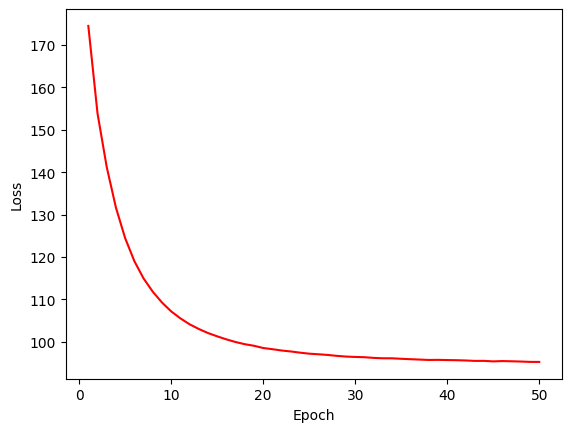

In [14]:
# loss curve
plt.plot(range(1, NUM_EPOCHS+1), loss_trace, 'r-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [15]:
for i, (x, y) in enumerate(test_loader):
  x, y  = x.to(DEVICE), y.to(DEVICE)
  outputs = model(x, y)
  first_person = [total_words[k] for k in x[0, :]]
  second_person_target = [total_words[k] for k in y[0, :]]
  second_person_model_output = [total_words[k] for k in outputs.argmax(axis=2)[:, 0]]
  print(f"First person speaking test sentence: {' '.join(first_person)}")
  print(f"Second person speaking target test sentence: {' '.join(second_person_target)}")
  print(f"Second person speaking model output sentence: {' '.join(second_person_model_output)}")
  print('-'*80)

First person speaking test sentence: <sos> i ll take this blouse and skirt please <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Second person speaking target test sentence: <sos> how would you like to pay <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Second person speaking model output sentence: <sos> how give you like to pay <eos> burgers up decent fund minimum withdraw business culinary break hanging culinary grow kilometers before statements save deliver simply page keeps being her
--------------------------------------------------------------------------------
First person speaking test sentence: <sos> good day to you how can i be of service today <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Second person speaking target test sentence: <sos> hello i d